In [5]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

C:\Users\Dawit\AppData\Local\Temp\ipykernel_5508\2867026071.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [8]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538521,72.598899,71.292311,71.545897,135480400
2020-01-03,71.833275,72.594040,71.608669,71.765651,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065155,72.671348,71.845377,72.415345,108872000
2020-01-08,73.224411,73.526303,71.768086,71.768086,132079200
...,...,...,...,...,...
2025-08-20,226.009995,230.470001,225.770004,229.979996,42263900
2025-08-21,224.899994,226.520004,223.779999,226.270004,30621200


<Axes: xlabel='Date'>

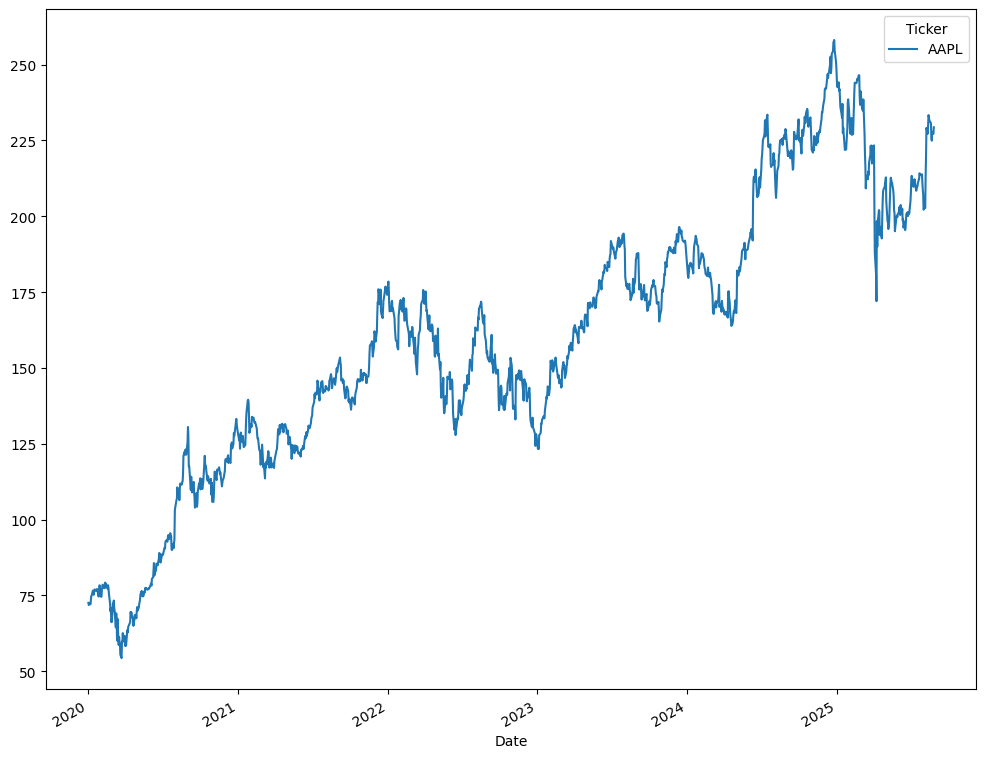

In [9]:
df.Close.plot(figsize=(12, 10))

In [10]:
scaler = StandardScaler()
df["Close"] = scaler.fit_transform(df['Close'])
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.933505
2020-01-03,-1.949249
2020-01-06,-1.936471
2020-01-07,-1.944072
2020-01-08,-1.918194
...,...
2025-08-20,1.492516
2025-08-21,1.467737
2025-08-22,1.531582


In [11]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])
data = np.array(data)


In [13]:
data

array([[[-1.93350527],
        [-1.94924884],
        [-1.93647097],
        ...,
        [-1.82557693],
        [-1.78455932],
        [-1.79715104]],

       [[-1.94924884],
        [-1.93647097],
        [-1.94407246],
        ...,
        [-1.78455932],
        [-1.79715104],
        [-1.79671861]],

       [[-1.93647097],
        [-1.94407246],
        [-1.9181938 ],
        ...,
        [-1.79715104],
        [-1.79671861],
        [-1.82887354]],

       ...,

       [[ 1.15566857],
        [ 1.09903105],
        [ 1.10995743],
        ...,
        [ 1.59408826],
        [ 1.49251624],
        [ 1.46773713]],

       [[ 1.09903105],
        [ 1.10995743],
        [ 1.13337061],
        ...,
        [ 1.49251624],
        [ 1.46773713],
        [ 1.53158238]],

       [[ 1.10995743],
        [ 1.13337061],
        [ 1.13024874],
        ...,
        [ 1.46773713],
        [ 1.53158238],
        [ 1.51818848]]], shape=(1390, 30, 1))

In [19]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :])
y_train = torch.from_numpy(data[:train_size, :-1, :])
X_test = torch.from_numpy(data[train_size:, :-1, :])
y_test = torch.from_numpy(data[train_size:, :-1, :])


In [22]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out
    